# Debug detsim city NB

### JAH 12/12/19

In [1]:
import time

%load_ext autoreload
%autoreload 2

import numpy             as np
import scipy             as sc
import scipy.stats       as st
import tables            as tb

from typing    import Callable
from typing    import Tuple
from typing    import List

import invisible_cities.io.mcinfo_io               as mcio
import invisible_cities.core    .system_of_units_c as system_of_units
import invisible_cities.core    .fit_functions     as fitf
import invisible_cities.database.load_db           as db

import myhistos                  as ht
import detsim.simulation.detsim  as ds

units = system_of_units.SystemOfUnits()

# Plotting configuration

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 5, 4
plt.rcParams["font.size"]               = 12
plt.rcParams["figure.max_open_warning"] = 100

## DetSim

In [3]:
detector, run_number = 'new', -1
detsimparams = ds.DetSimParameters(detector, run_number)
#detsimparams.next_detector(db)
print(detsimparams.nsipms)

1792


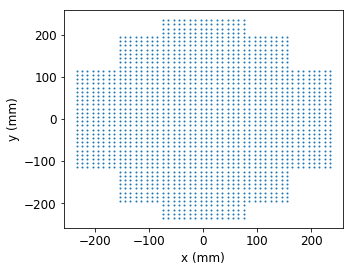

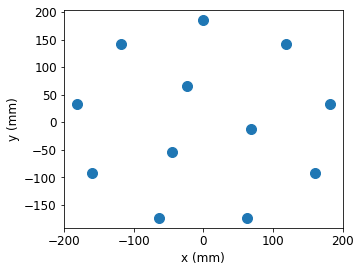

In [4]:
plt.scatter(detsimparams.x_sipms, detsimparams.y_sipms, s = 1.)
plt.xlabel('x (mm)'); plt.ylabel('y (mm)');
plt.figure()
plt.scatter(detsimparams.x_pmts, detsimparams.y_pmts, s = 1e2)
plt.xlabel('x (mm)'); plt.ylabel('y (mm)');

## Data

In [5]:
datadir      = '/Users/hernando/investigacion/NEXT/work/detsim/detsim/test_data/'
datafilename = 'neut_full_test.sim.h5'

In [6]:
def hits_generator():
    datahits = mcio.load_mchits_df(datadir + datafilename)
    hitsgroup = datahits.groupby('event_id')
    print('size ', len(hitsgroup))
    for ievt, hitsdf in hitsgroup:
        print('event ', ievt)
        yield(ievt, hitsdf)

In [7]:
it = hits_generator()

In [8]:
evt, hits = next(it)

size  3
event  0


In [9]:
xs, ys, zs, enes = ds.get_deposits(hits)
print('total energy', np.sum(enes) / units.keV, ' keV');

total energy 336.645245552063  keV


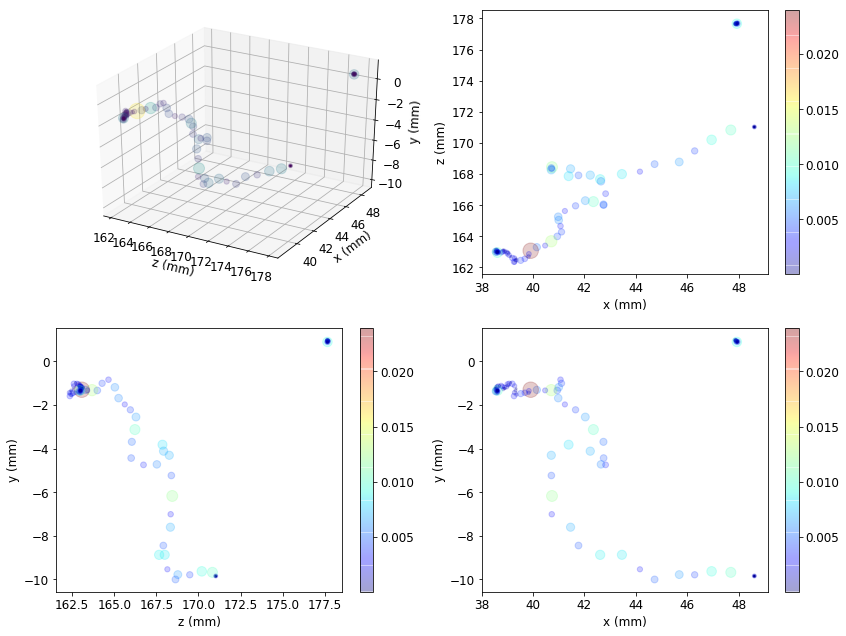

In [10]:
ht.graph_event(xs, ys, zs, enes, scale = 1e4)

## Generate - drift - diffuse electrons

total energy  336.645245552063  keV
number of secondary elctrons  15021
number of drifted electrons  15020
number of diffused electrons  15020
longitudinal diffusion  1.2306540613431896
transverse diffusion 4.102180204477299


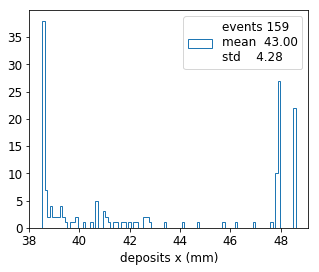

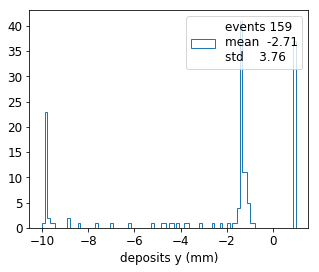

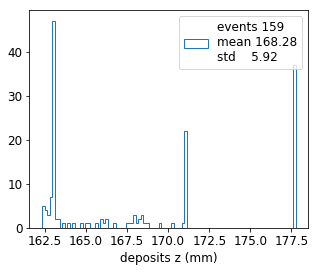

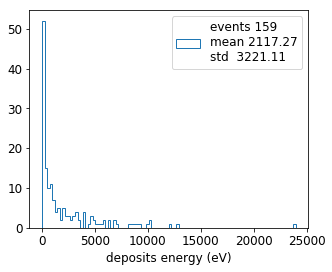

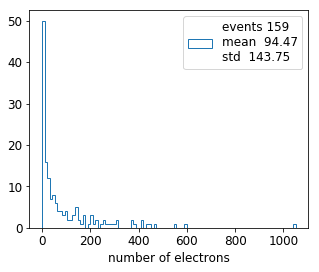

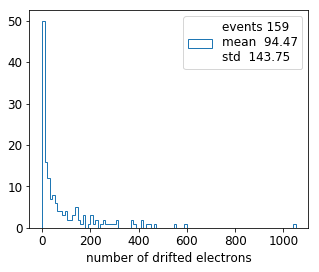

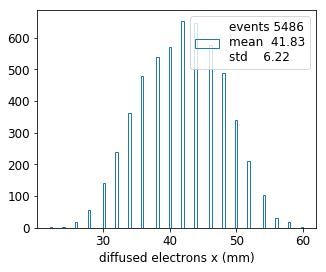

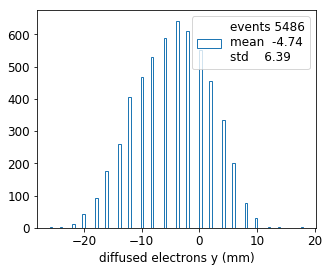

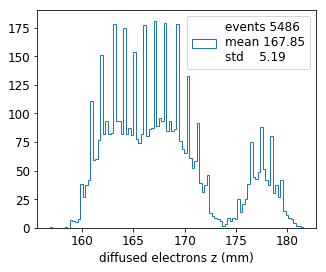

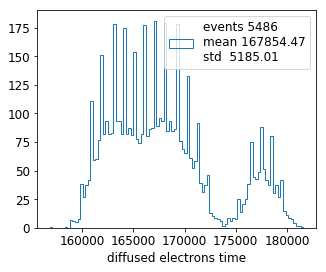

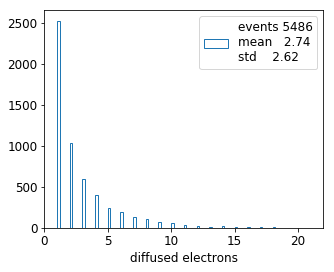

In [11]:
plot = True
# generate deposits
#xs, ys, zs, enes = ds.generate_deposits(xsigma = 0.4)
if (plot):
    print('total energy ', np.sum(enes) / units.keV, ' keV')
    ht.hist(xs); plt.xlabel('deposits x (mm)')
    ht.hist(ys); plt.xlabel('deposits y (mm)')
    ht.hist(zs); plt.xlabel('deposits z (mm)')
    ht.hist(enes / units.eV); plt.xlabel('deposits energy (eV)')
    
# generate electrons
nes = ds.generate_electrons(enes)
if (plot):
    print('number of secondary elctrons ', np.sum(nes))
    ht.hist(nes, 100); plt.xlabel('number of electrons')

# drift electrons
nes = ds.drift_electrons(zs, nes)
if (plot):
    print('number of drifted electrons ', np.sum(nes));
    ht.hist(nes, 100); plt.xlabel('number of drifted electrons')

# diffuse electrons
dxs, dys, dzs, dnes = ds.diffuse_electrons(xs, ys, zs, nes)
dts                 = dzs / detsimparams.drift_velocity
if (plot):
    print('number of diffused electrons ', np.sum(nes));
    print('longitudinal diffusion ', detsimparams.longitudinal_diffusion * np.sqrt(np.mean(zs)))
    print('transverse diffusion'   , detsimparams.transverse_diffusion * np.sqrt(np.mean(zs)))
    ht.hist(dxs  , 100); plt.xlabel('diffused electrons x (mm)')
    ht.hist(dys  , 100); plt.xlabel('diffused electrons y (mm)')
    ht.hist(dzs  , 100); plt.xlabel('diffused electrons z (mm)')
    ht.hist(dts  , 100); plt.xlabel('diffused electrons time')
    ht.hist(dnes , 100); plt.xlabel('diffused electrons')

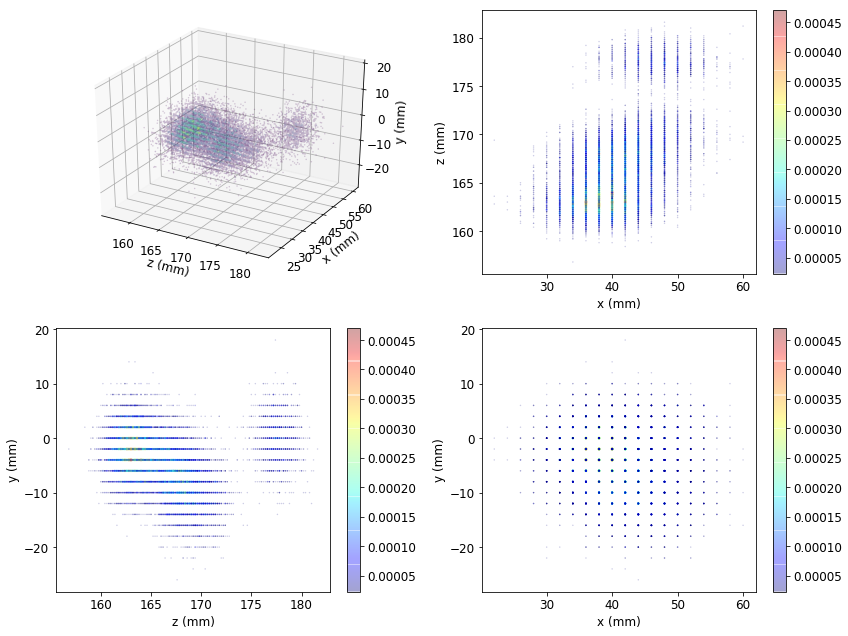

In [12]:
#ht.graph_event( xs,  ys,  zs, enes                  , scale = 1e4);
ht.graph_event(dxs, dys, dzs, dnes * detsimparams.wi, scale = 1e4);

number of EL photons 15018112.450654585
pes  [144573.11339554 144237.03521112 149102.32768614 130692.79841498
 126611.4221564  124852.62067558 126082.83798792 129842.24102212
 134580.95036329 138042.8536043  138367.81219153 135372.86965208]
pes  [ 5.42811477  5.31705891  5.19043648 ... 14.27006924 14.86444598
 15.3828215 ]


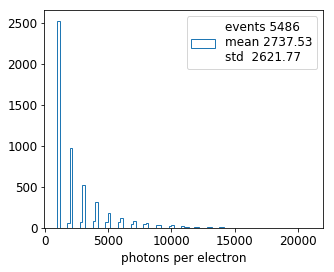

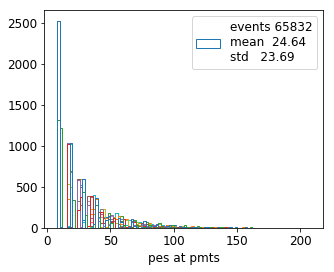

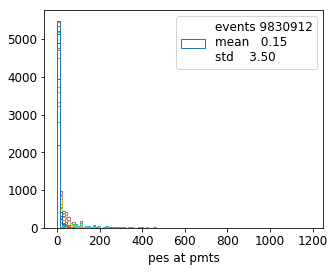

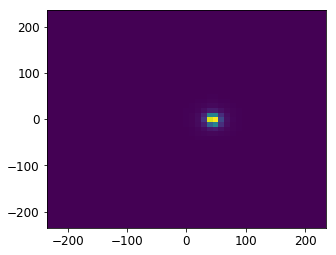

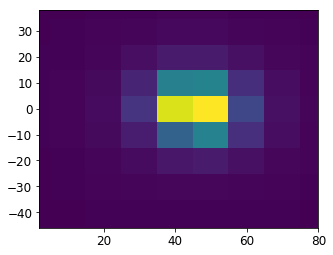

In [13]:
def get_xybins():
    def _bins(xxs):
        xs = np.sort(xxs)
        dx   = 0.5*(xs[1] - xs[0])
        bins = np.append(xs - dx, xs[-1] + dx)
        return bins
    return _bins(detsimparams.x_sipms), _bins(detsimparams.y_sipms)   

photons = ds.generate_EL_photons(dnes)
if (plot):
    print('number of EL photons', np.sum(photons))
    ht.hist(photons, 100); plt.xlabel('photons per electron');

pes_pmts = ds.estimate_pes_at_pmts(dxs, dys, photons)
if (plot):
    print('pes ', np.sum(pes_pmts, axis = 0))
    ht.hist(pes_pmts, 100); plt.xlabel('pes at pmts')
    
pes_sipms = ds.estimate_pes_at_sipms(dxs, dys, photons)
if (plot):
    print('pes ', np.sum(pes_sipms, axis = 0))
    ht.hist(pes_sipms, 100); plt.xlabel('pes at pmts')
    plt.figure();
    xybins = get_xybins()
    detsimparams.x_sipms[1] - detsimparams.x_sipms[0]
    int_pes_sipms  = np.sum(pes_sipms, axis = 0)
    plt.hist2d(detsimparams.x_sipms, detsimparams.y_sipms, bins = xybins, weights = int_pes_sipms);
    plt.figure()
    plt.hist2d(detsimparams.x_sipms, detsimparams.y_sipms, bins = xybins, weights = int_pes_sipms);
    plt.xlim((np.min(dxs) - 20, np.max(dxs) + 20))
    plt.ylim((np.min(dys) - 20, np.max(dys) + 20))

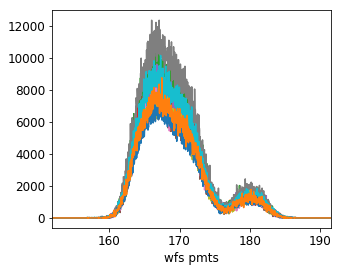

In [14]:
times_pmts, wfs_pmts = ds.create_wfs_pmts(dts, pes_pmts)
#print(times_pmts.shape, wfs_pmts.shape)
if (plot):
    xcenters = times_pmts
    plt.plot(xcenters / units.mus, wfs_pmts); plt.xlabel('wfs pmts')
    plt.xlim((np.min(dts) /units.mus - 5, np.max(dts) / units.mus + 10));

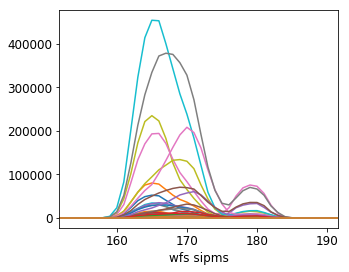

In [15]:
times_sipms, wfs_sipms = ds.create_wfs_sipms(dts, pes_sipms)
if (plot):
    xcenters = times_sipms
    plt.plot(xcenters / units.mus, wfs_sipms); plt.xlabel('wfs sipms')
    plt.xlim((np.min(dts) /units.mus - 5, np.max(dts) / units.mus + 10));

## One go

In [16]:
def plot_wfs(wfs_pmts, wfs_sipms):
    nbins  = int(detsimparams.wf_buffer_time / detsimparams.wf_pmt_bin_time)
    times  = np.arange(nbins) * detsimparams.wf_pmt_bin_time
    plt.figure()
    plt.plot(times / units.mus, wfs_pmts); plt.xlabel('wfs pmts')
    plt.figure()
    plt.plot(times / units.mus, wfs_pmts); plt.xlabel('wfs pmts')
    plt.xlim((np.min(dts) /units.mus - 5, np.max(dts) / units.mus + 10));

    nbins  = int(detsimparams.wf_buffer_time / detsimparams.wf_sipm_bin_time)
    times  = np.arange(nbins) * detsimparams.wf_sipm_bin_time
    plt.figure()
    plt.plot(times / units.mus, wfs_sipms); plt.xlabel('wfs sipms')
    plt.figure()
    plt.plot(times / units.mus, wfs_sipms); plt.xlabel('wfs sipms')
    plt.xlim((np.min(dts) /units.mus - 5, np.max(dts) / units.mus + 10));

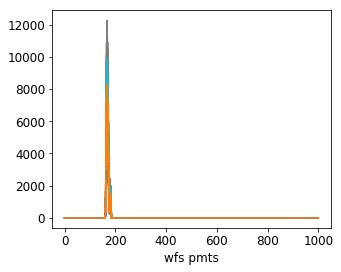

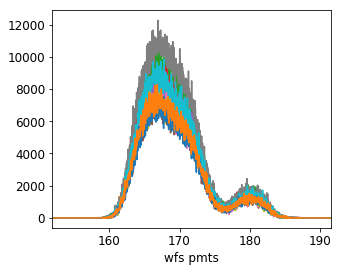

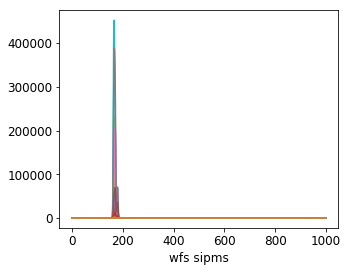

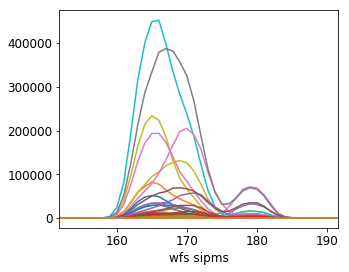

In [17]:
generate_wfs = ds.get_function_generate_wfs()
wfs_pmts, wfs_sipms = generate_wfs(hits)
if (plot): plot_wfs(wfs_pmts, wfs_sipms)

## Timings

In [18]:
def time_to_simulate_one_event(hits, n = 1):
    t0 = time.time()
    for i in range(n):
        generate_wfs(hits)
    return (time.time() - t0) / n

In [19]:
dtsim = time_to_simulate_one_event(hits, n = 10)
print('total ', dtsim, 's')

total  1.2611161947250367 s


event  1
total energy 223.58062863349915  keV
total  0.899015998840332 s


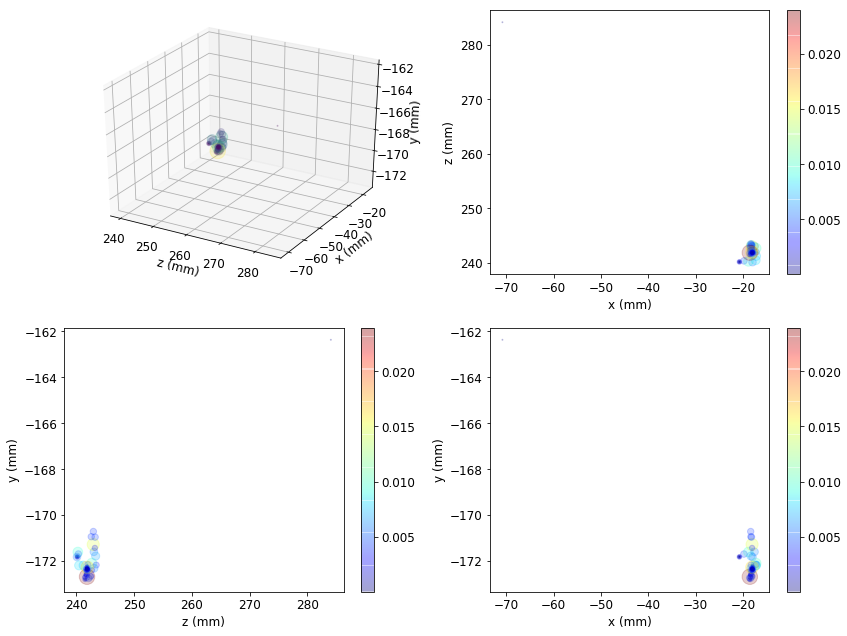

In [20]:
evt, hits = next(it)
xs, ys, zs, enes = ds.get_deposits(hits)
print('total energy', np.sum(enes) / units.keV, ' keV');
ht.graph_event(xs, ys, zs, enes, scale = 1e4)
dtsim = time_to_simulate_one_event(hits, n = 10)
print('total ', dtsim, 's')

event  2
total energy 126.0291337966919  keV
total  0.7559708833694458 s


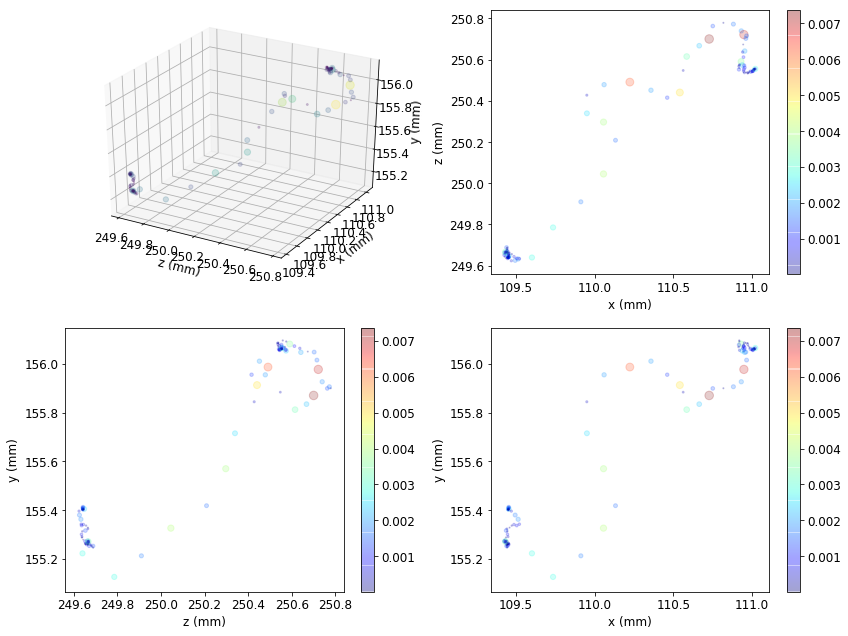

In [21]:
evt, hits = next(it)
xs, ys, zs, enes = ds.get_deposits(hits)
print('total energy', np.sum(enes) / units.keV, ' keV');
ht.graph_event(xs, ys, zs, enes, scale = 1e4)
dtsim = time_to_simulate_one_event(hits, n = 10)
print('total ', dtsim, 's')